# Will the Employee Quit or Stay?

In [1]:
from __future__ import print_function
from ipywidgets import interact
%matplotlib inline
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas_profiling
plt.style.use('seaborn')
warnings.simplefilter('ignore')

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.rcParams['figure.figsize'] = (12,8)

### Exploratory Data Analysis

In [3]:
data = pd.read_csv('data/employee_data.csv')
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
data.profile_report(title='data report')

In [5]:
options = ['salary', 'time_spend_company',
         'Work_accident', 'promotion_last_5years',
         'department']
def f(x):
    pd.crosstab(index=data[x], columns=data['quit']).plot(kind='bar')
    plt.ylabel('Turnover Frequency')
    plt.xlabel(' '.join(x.split('_')).title())

interact(f, x=options)

interactive(children=(Dropdown(description='x', options=('salary', 'time_spend_company', 'Work_accident', 'pro…

<function __main__.f(x)>

### Encode Categorical Features

In [6]:
data = pd.get_dummies(data, columns=['salary', 'department'])

### Visualize Class Imbalance

Let us see if our data is balanced or imbalanced with the following:

In [7]:
data['quit'].value_counts()/len(data)

0    0.761917
1    0.238083
Name: quit, dtype: float64

We have more instances of 'not quit' employees than 'quit' employees.
We can visualize the above using the yellowbrick library, which should always be a first stop.

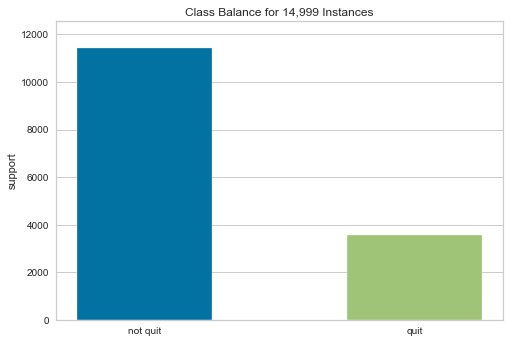

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1a32ff38d0>,
             labels=['not quit', 'quit'])

In [8]:
from yellowbrick.target import class_balance

class_balance(data['quit'], labels=['not quit', 'quit'])

Because of the above imbalance, we have to make sure we apply stratified sampling when we are creating our training and validation/test datasets. Sklearn's train_test_split does this as a default but we can always double-check with yellowbrick.target's class_imbalance.

### Create Training and Test Sets

In [9]:
from sklearn.model_selection import train_test_split

X = data.drop('quit', axis=1)
y = data['quit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

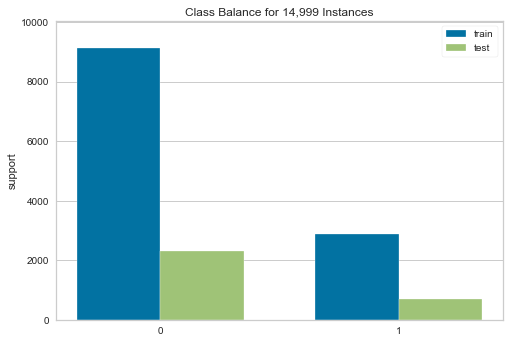

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1a33205ba8>)

In [10]:
class_balance(y_train, y_test)

### Build a Decision Tree Classifier with Interactive Controls

In [11]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from IPython.display import SVG, display, Image
from graphviz import Source
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from subprocess import call
import matplotlib.image as mpimg

In [12]:
@interact
def plot_interactive_tree(crit=['gini', 'entropy'],
             split=['best', 'random'],
             depth=IntSlider(min=1, max=30, value=2, continuous_update=False),
             min_split=IntSlider(min=2, max=5, value=2, continuous_update=False),
             min_leaf=IntSlider(min=1, max=5, value=1, continuous_update=False)):
    model = DecisionTreeClassifier(random_state=0,
                                 criterion=crit,
                                 splitter=split,
                                 max_depth=depth,
                                 min_samples_split=min_split,
                                 min_samples_leaf=min_leaf)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred, target_names=['stay', 'quit']))
    
    graph = Source(tree.export_graphviz(model,
                                       feature_names=X_train.columns,
                                       class_names=['stay', 'quit'],
                                       filled=True))
    
    display(Image(data=graph.pipe(format='png')))
    return model

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Build a Random Forest Classifier with Interactive Controls

Although randomization increases bias, it is possible to get a reduction in variance of the ensemble. Random forests are one of the most robust machine learning algorithms for a variety of probelms.
* Randomization and averaging lead to a reduction in variance and improve accuracy
* The implementations are parallelizable
* Memory consumption and training time can be reduced by bootstrapping
* Sampling features and not solely sampling examples is crucial to improving accuracy

In [13]:
@interact
def plot_interactive_rf(crit=['gini', 'entropy'],
                        bootstrap=['True', 'False'],
                        depth=IntSlider(min=1, max=30, value=3, continuous_update=False),
                        forests=IntSlider(min=1, max=200, value=100, continuous_update=False),
                        min_split=IntSlider(min=2, max=5, value=2, continuous_update=False),
                        min_leaf=IntSlider(min=1, max=5, value=1, continuous_update=False)):
    
    model = RandomForestClassifier(random_state=1,
                                   criterion=crit,
                                   bootstrap=bootstrap,
                                   n_estimators=forests,
                                   max_depth=depth,
                                   min_samples_split=min_split,
                                   min_samples_leaf=min_leaf,
                                   n_jobs=-1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred, target_names=['stay', 'quit']))
    
    num_tree = model.estimators_[0]
    print('Visualizing Tree: 0')
    
    graph = Source(tree.export_graphviz(num_tree,
                                       feature_names=X_train.columns,
                                       class_names=['stay', 'quit'],
                                       filled=True))
    
    display(Image(data=graph.pipe(format='png')))
    return model


interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Feature Importance Plots and Evaluation Metrics

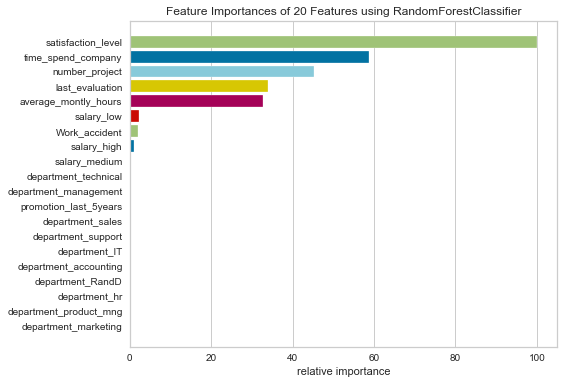

In [14]:
from yellowbrick.model_selection import FeatureImportances

rf = RandomForestClassifier(bootstrap='True', max_depth=8, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=28, n_jobs=-1,
                       random_state=1)

viz = FeatureImportances(rf)
viz.fit(X_train, y_train)
viz.show()

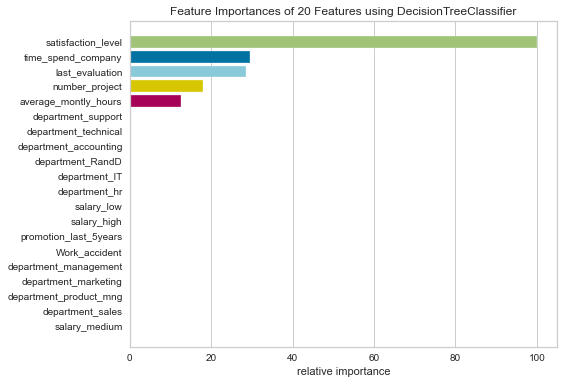

In [15]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=3,
                       random_state=0)

viz = FeatureImportances(dt)
viz.fit(X_train, y_train)
viz.show()

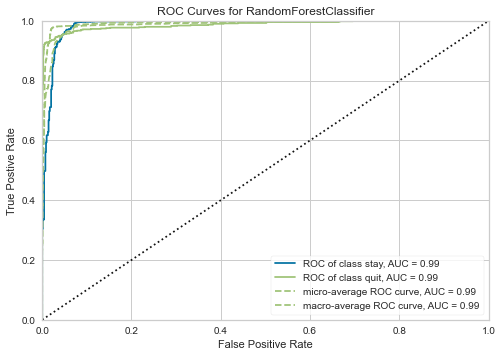

In [16]:
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

visualizer = ROCAUC(rf, classes=['stay', 'quit'])

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show()          

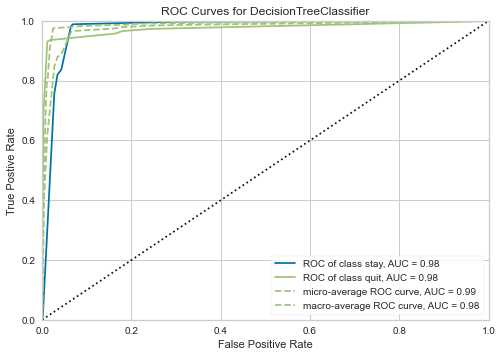

In [17]:
visualizer = ROCAUC(dt, classes=['stay', 'quit'])

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show()   

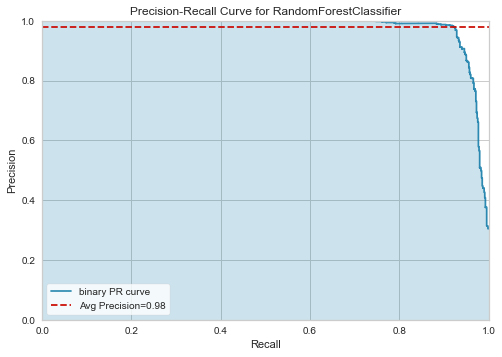

In [18]:
visualizer = PrecisionRecallCurve(rf, classes=['stay', 'quit'])

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show()   

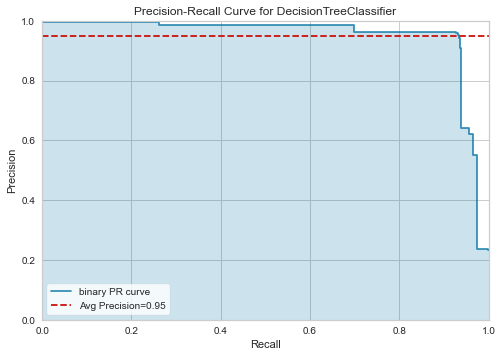

In [19]:
visualizer = PrecisionRecallCurve(dt, classes=['stay', 'quit'])

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show()   